# Modeling Primer

In [1]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import yfinance as yf
import scipy.stats as sp
import matplotlib.pyplot as plt

## Setup
In this notebook we will try to create some [Ordinary Least Squares (OLS)](https://www.schmidheiny.name/teaching/ols2up.pdf) models to predict stock price movement. To prepare, there are several csv files in this directory that are downloaded from the [FRED webiste](https://fred.stlouisfed.org) - an excellent source for macroeconomic data. We will learn:
* How to load data into Python from a [csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) or [excel](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html) file using [Pandas](https://pandas.pydata.org) 
* Also how to use the [yfinance](https://pypi.org/project/yfinance/) package to pull in stock price data from Yahoo! finance 
* Explore the data with some visualizations using [matplotlib](https://matplotlib.org), which is nicely integrated with pandas
* Create a model using the [statsmodels api](https://www.statsmodels.org/stable/index.html) 
* Various diagnostic techniques for timeseries modeling available to us via statsmodels and [scikit-learn](https://scikit-learn.org/stable/)

### Part 1: Pandas
Pandas has become the standard for dataframes in the Python world due to the easy power that it provides the user. We will go over some useful features as we use Pandas to expore our data and use it for regression, but I would encourage you to explore the site linked in the title of this section as well as [this cheat sheet](http://datacamp-community-prod.s3.amazonaws.com/dbed353d-2757-4617-8206-8767ab379ab3) for other very useful methods.


In [2]:
# read in csv and look at top 
# note: pd.read_excel() can be used for excel files with optional arg 
# sheet_name to specify which tab
real_gdp = pd.read_csv('GDPC1.csv')
# note: .tail() can be used to look at bottom
real_gdp.head()

,DATE,GDPC1
0,1947-01-01,2033.061
1,1947-04-01,2027.639
2,1947-07-01,2023.452
3,1947-10-01,2055.103
4,1948-01-01,2086.017


In [3]:
# now let's check out what else we can do with the dataframe
# dir() can be used with any object in python and is very useful for exploring 
# functionality of a package
dir(real_gdp)

['DATE',
 'GDPC1',
 'T',
 '_AXIS_ALIASES',
 '_AXIS_IALIASES',
 '_AXIS_LEN',
 '_AXIS_NAMES',
 '_AXIS_NUMBERS',
 '_AXIS_ORDERS',
 '_AXIS_REVERSED',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_priority__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex

We note a few things about our GDP data frame as it currently stands that need fixed:
* Bold indicates index(row names)/columns - it has a generic index (which starts at 0, as all python indexing does) but we prefer this to be the date column
* We haven't seen yet - but our date column is actually strings of the date -  we want to change this to a datetime format to avoid issues later on (none specifically, just best practice)



In [4]:
# note we make changes to our dataframe - so we make a copy of it, thus later in the 
# code we can refer back to the original if need be. while not important in this 
# example, if you are loading in huge dataframes - it is advisable not to write over
# the original load because often loading the data takes longer than the computation
data = real_gdp.set_index(pd.to_datetime(real_gdp['DATE']))
data = data.drop('DATE', axis = 1)
data.head()

,GDPC1
DATE,
1947-01-01,2033.061
1947-04-01,2027.639
1947-07-01,2023.452
1947-10-01,2055.103
1948-01-01,2086.017


We're going to be loading a few data frames from csv and we will need to do these same steps for each of them. Whenever there's a repeated process in our data pipeline such as this, it is advisable to make it into a function so we can simplify our main script.


In [5]:
# note - I've used an alternative method for changing the index in the function below 
# note - since this data is small size and fast to load, I've included the data load 
# step in the function but for bigger datasets, this would not be advisable like we 
# discussed earlier
def preprocess(data):
    data = pd.read_csv(data)
    data.index = pd.to_datetime(data['DATE'])
    data = data.drop('DATE', axis = 1)
    return data

In [6]:
pce = preprocess('PCEC96.csv')
disposable_per_capita = preprocess('A229RX0.csv')
disposable = preprocess('DSPIC96.csv')
gdp = preprocess('GDPC1.csv')
pce.head()

,PCEC96
DATE,
2002-01-01,8981.7
2002-02-01,9022.0
2002-03-01,9020.6
2002-04-01,9066.3
2002-05-01,9031.8


Note the above data for PCE was monthly while GDP was quarterly - we'll see one wawy to account for this later.

### Part 2: Yfinance
Now let's look into loading stock prices, Microsoft is a fun case study! Note you can change the ticker inside the first line of the below cell to change our analysis to any ticker that you can find info for on Yahoo! Finance.

In [7]:
msft = yf.Ticker("MSFT")
msft.info

{'zip': '98052',
 'sector': 'Technology',
 'fullTimeEmployees': 144000,
 'longBusinessSummary': 'Microsoft Corporation develops, licenses, and supports software, services, devices, and solutions worldwide. Its Productivity and Business Processes segment offers Office, Exchange, SharePoint, Microsoft Teams, Office 365 Security and Compliance, and Skype for Business, as well as related Client Access Licenses (CAL); Skype, Outlook.com, and OneDrive; LinkedIn that includes Talent and marketing solutions, and subscriptions; and Dynamics 365, a set of cloud-based and on-premises business solutions for small and medium businesses, large organizations, and divisions of enterprises. Its Intelligent Cloud segment licenses SQL and Windows Servers, Visual Studio, System Center, and related CALs; GitHub that provides a collaboration platform and code hosting service for developers; and Azure, a cloud platform. It also provides support services and Microsoft consulting services to assist customers i

In [8]:
# ![](https://logo.clearbit.com/microsoft.com)

In [9]:
# get historical market data
hist = msft.history(period = 'max')
hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,0.06,0.06,0.06,0.06,1031788800,0.0,0.0
1986-03-14,0.06,0.07,0.06,0.06,308160000,0.0,0.0
1986-03-17,0.06,0.07,0.06,0.07,133171200,0.0,0.0
1986-03-18,0.07,0.07,0.06,0.06,67766400,0.0,0.0
1986-03-19,0.06,0.06,0.06,0.06,47894400,0.0,0.0


### Part 3: Visualization with Matplotlib
Here we introduce matplotlib, which has been the dominant plotting engine in Python for some time. Their website, linked above, has a great catalog of sample graphs and is a great place to start when using a certain type of graph for the first time.

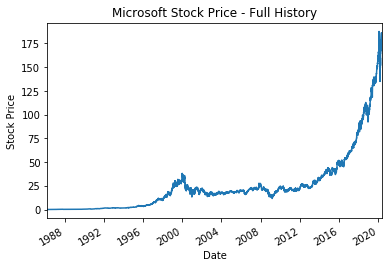

In [10]:
%matplotlib inline
hist['Close'].plot()
plt.title('Microsoft Stock Price - Full History')
plt.ylabel('Stock Price')
plt.savefig('Microsoft.png')

Clearly the above data series is not stationary - a critical assumption of ols, so lets calculate a percentage growth rate for stock price and perhaps this will be a 
more useful variable to model on



Text(0, 0.5, 'Stock Price')

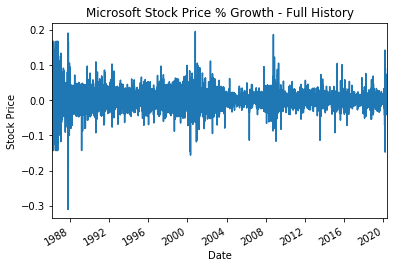

In [11]:
# note - we use .dropna() to remove the first data point for which the formula cannot 
# calculate 
price_growth = (hist['Close'].diff()/hist['Close'].shift(1)).dropna()
# we create a plot of the growth over time
price_growth.plot()
plt.title('Microsoft Stock Price % Growth - Full History')
plt.ylabel('Stock Price')


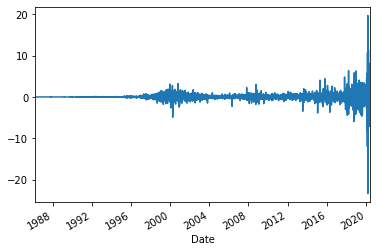

In [12]:
price_diff = hist['Close'].diff().dropna()
price_diff.plot()

Between the two graphs, we can see that the percentage difference is much more random-walk like. As changes in price get greater as the price itself gets greater, causing some heteroskedasticity concerns. Thus % difference will be our preferred dependent variable for the model. 

We'll start by building a model on GDP, since it is generally a great economic indicator. Let's explore this variable in a similar way to how we explored our stock price.

Text(0, 0.5, 'Stock Price')

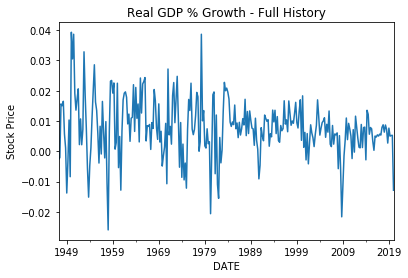

In [13]:
# note - we use .dropna() to remove the first data point for which the formula cannot 
# calculate 
gdp_growth = (gdp['GDPC1'].diff()/gdp['GDPC1'].shift(1)).dropna()
# we create a plot of the growth over time
gdp_growth.plot()
plt.title('Real GDP % Growth - Full History')
plt.ylabel('Stock Price')

We see that this is good, however we may have some heteroskedasticity (non-constant variance) concerns as the earlier part of the data series shows higher peaks and valleys than the later part. While heteroskedasticity concerns the residuals, we note that stock price is not an adjusted weight, whereas our macroeconomics variables are represented as inflation adjusted, calculated based off a base year (2012 in our case). Thus we should check if differencing would be a more promising approach.

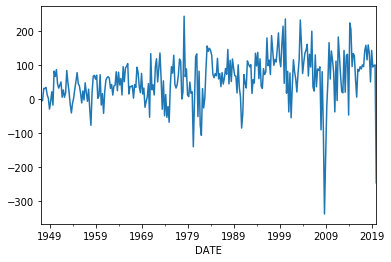

In [14]:
gdp_diff = gdp['GDPC1'].diff().dropna()
gdp_diff.plot()

This looks a bit more like a random walk so we will proceed to model based off this.

### Part 4: Modeling with statsmodels
We will try to build a simple model with real gdp as our independent variable predicting the stock price. We will add an intercept as well. Our first step is to prepare the data to pass to OLS. We will see this is generally the bulk of the work, as producing the model is very simple using statsmodels. First let's take a look at our two dataframes.



In [15]:
# note display is specific to the jupyter notebook, use print for any python script
# to print to the python console/terminal, depending how you execute the script
display(price_growth)
display(gdp_diff)

Date
1986-03-14    0.000000
1986-03-17    0.166667
1986-03-18   -0.142857
1986-03-19    0.000000
1986-03-20    0.000000
                ...   
2020-05-28   -0.002255
2020-05-29    0.010198
2020-06-01   -0.002292
2020-06-02    0.011377
2020-06-03    0.002434
Name: Close, Length: 8626, dtype: float64

DATE
1947-04-01     -5.422
1947-07-01     -4.187
1947-10-01     31.651
1948-01-01     30.914
1948-04-01     34.433
               ...   
2019-01-01    143.733
2019-04-01     94.579
2019-07-01     99.252
2019-10-01    100.858
2020-01-01   -247.268
Name: GDPC1, Length: 292, dtype: float64

There's some problems for us to solve here. We note that the stock price dataframe has closing prices for all business days since 1986, while the GDP data frame has quarterly measures from 1947. Lets begin by finding the closing price for each quarter for the stock so that it will match up similar to the representation of GDP. We also note that GDP is indexed by the beginning of each quarter's date, so we will have to align this as well so that we can clearly represent our dataframes and confirm we have successfully aligned the data.

In [16]:
prices = hist['Close']
prices
keep = []
for i in range(len(prices.index)-1):
    if prices.index[i].month in [3,6,9,12]:
        if prices.index[i+1].month != prices.index[i].month:
            keep.append(prices.index[i])
keep

[Timestamp('1986-03-31 00:00:00'),
 Timestamp('1986-06-30 00:00:00'),
 Timestamp('1986-09-30 00:00:00'),
 Timestamp('1986-12-31 00:00:00'),
 Timestamp('1987-03-31 00:00:00'),
 Timestamp('1987-06-30 00:00:00'),
 Timestamp('1987-09-30 00:00:00'),
 Timestamp('1987-12-31 00:00:00'),
 Timestamp('1988-03-31 00:00:00'),
 Timestamp('1988-06-30 00:00:00'),
 Timestamp('1988-09-30 00:00:00'),
 Timestamp('1988-12-30 00:00:00'),
 Timestamp('1989-03-31 00:00:00'),
 Timestamp('1989-06-30 00:00:00'),
 Timestamp('1989-09-29 00:00:00'),
 Timestamp('1989-12-29 00:00:00'),
 Timestamp('1990-03-30 00:00:00'),
 Timestamp('1990-06-29 00:00:00'),
 Timestamp('1990-09-28 00:00:00'),
 Timestamp('1990-12-31 00:00:00'),
 Timestamp('1991-03-28 00:00:00'),
 Timestamp('1991-06-28 00:00:00'),
 Timestamp('1991-09-30 00:00:00'),
 Timestamp('1991-12-31 00:00:00'),
 Timestamp('1992-03-31 00:00:00'),
 Timestamp('1992-06-30 00:00:00'),
 Timestamp('1992-09-30 00:00:00'),
 Timestamp('1992-12-31 00:00:00'),
 Timestamp('1993-03-

This was successful. We can see that we have isolated the business day for each quarter from the stock price data frame. Now we need to use this list of timestamps to filter our dataframe to these stock prices. Then we will want to change the index, so that it shows the first day of each quarter, instead of the last business day.

In [17]:
prices_quarterly = prices.loc[keep]
new_index = []
for i in prices_quarterly.index:
    new_value = i.replace(month = i.month-2, day = 1)
    new_index.append(new_value)
prices_quarterly.index = new_index
prices_quarterly

1986-01-01      0.06
1986-04-01      0.07
1986-07-01      0.06
1986-10-01      0.11
1987-01-01      0.21
               ...  
2019-01-01    116.08
2019-04-01    132.33
2019-07-01    137.80
2019-10-01    156.83
2020-01-01    157.27
Name: Close, Length: 137, dtype: float64

Now we are ready to merge in the dataframes and only keep the data that is relevant for both variables (ie remove 1947-1986 from our real gdp variable). First let's make a function out of what we have just done, so that we can reuse in the future. 


In [18]:
def quarterly_close(prices):
    keep = []
    for i in range(len(prices.index)-1):
        if prices.index[i].month in [3,6,9,12]:
            if prices.index[i+1].month != prices.index[i].month:
                keep.append(prices.index[i])
    prices_quarterly = prices.loc[keep]
    new_index = []
    for i in prices_quarterly.index:
        new_value = i.replace(month = i.month-2, day = 1)
        new_index.append(new_value)
    prices_quarterly.index = new_index
    return prices_quarterly
    
prices_quarterly = quarterly_close(prices)
prices_quarterly

1986-01-01      0.06
1986-04-01      0.07
1986-07-01      0.06
1986-10-01      0.11
1987-01-01      0.21
               ...  
2019-01-01    116.08
2019-04-01    132.33
2019-07-01    137.80
2019-10-01    156.83
2020-01-01    157.27
Name: Close, Length: 137, dtype: float64

This was successful, so let's put the two variables together to make sure we don't run into any dimension issues when we use OLS. Recall we wanted to use the price growth (in %) with the gdp difference

,Stock Price Quarterly % Growth,GDP difference
1947-01-01,NaN,NaN
1947-04-01,NaN,-5.422
1947-07-01,NaN,-4.187
1947-10-01,NaN,31.651
1948-01-01,NaN,30.914
...,...,...
2019-01-01,0.166164,143.733
2019-04-01,0.139990,94.579
2019-07-01,0.041336,99.252
2019-10-01,0.138099,100.858


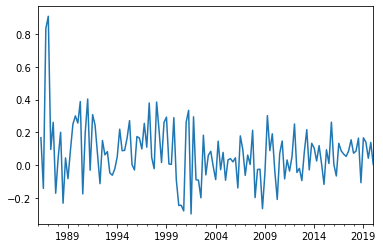

In [19]:
prices_quarterly_growth = prices_quarterly.diff()/prices_quarterly.shift(1)
prices_quarterly_growth.plot()
gdp_diff = gdp['GDPC1'].diff()
reg_data = pd.concat([prices_quarterly_growth, gdp_diff], axis = 1)
reg_data.columns = ['Stock Price Quarterly % Growth', 'GDP difference']
display(reg_data)

We know our data has no missing values, that's why this next step is okay. Be cautious to deal with missing values prior to doing this step as it will remove the row for any missing value, which is dangerous if that value is part of our intended development period. 


In [20]:
reg_data = reg_data.dropna()
reg_data

,Stock Price Quarterly % Growth,GDP difference
1986-04-01,0.166667,36.700
1986-07-01,-0.142857,78.336
1986-10-01,0.833333,44.382
1987-01-01,0.909091,61.909
1987-04-01,0.095238,90.303
...,...,...
2019-01-01,0.166164,143.733
2019-04-01,0.139990,94.579
2019-07-01,0.041336,99.252
2019-10-01,0.138099,100.858


We're pretty close now. To use statsmodels ols function we need to pass it y - our dependent variable and X - our design matrix. Thus we have to split this up again, then we will add our constant to the design matrix

In [21]:
# note here we use positional indexing to draw out the data, we could also use row and
# column names using the .loc[] capability of pandas
y = reg_data.iloc[:,0]
display(y)
X = reg_data.iloc[:,1]
X = sm.add_constant(X)
display(X)

1986-04-01    0.166667
1986-07-01   -0.142857
1986-10-01    0.833333
1987-01-01    0.909091
1987-04-01    0.095238
                ...   
2019-01-01    0.166164
2019-04-01    0.139990
2019-07-01    0.041336
2019-10-01    0.138099
2020-01-01    0.002806
Name: Stock Price Quarterly % Growth, Length: 136, dtype: float64

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,const,GDP difference
1986-04-01,1.0,36.700
1986-07-01,1.0,78.336
1986-10-01,1.0,44.382
1987-01-01,1.0,61.909
1987-04-01,1.0,90.303
...,...,...
2019-01-01,1.0,143.733
2019-04-01,1.0,94.579
2019-07-01,1.0,99.252
2019-10-01,1.0,100.858


Now we are ready to pass this to OLS and look at a summary of the model

In [22]:
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     Stock Price Quarterly % Growth   R-squared:                       0.011
Model:                                        OLS   Adj. R-squared:                  0.003
Method:                             Least Squares   F-statistic:                     1.434
Date:                            Wed, 03 Jun 2020   Prob (F-statistic):              0.233
Time:                                    19:09:07   Log-Likelihood:                 41.576
No. Observations:                             136   AIC:                            -79.15
Df Residuals:                                 134   BIC:                            -73.33
Df Model:                                       1                                         
Covariance Type:                        nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0554      0.022      2.561      0.012       0.013       0.098
GDP difference     0.0002      0.000      1.197      0.233      -0.000       0.001
==============================================================================
Omnibus:                       46.544   Durbin-Watson:                   1.749
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              150.486
Skew:                           1.250   Prob(JB):                     2.10e-33
Kurtosis:                       7.506   Cond. No.                         159.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We see that we have an insignificant variable, as evidenced by the low p-value on the GDP Difference parameter. Also, our R-squared is quite weak, meaning we might be wise to consider a different explanatory variable. For fast prototyping, let's define a function that will take in our reg data frame - with y as the first column and the rest of the columns as regressor variables, and create the model. 

In [23]:
# note we also return y and X because we will need them later for more exploration of 
# our candidate model
def create_model(reg_data):
    y = reg_data.iloc[:,0]
    X = reg_data.iloc[:,1]
    X = sm.add_constant(X)
    return sm.OLS(y,X).fit(), y, X

model, y, X = create_model(reg_data)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     Stock Price Quarterly % Growth   R-squared:                       0.011
Model:                                        OLS   Adj. R-squared:                  0.003
Method:                             Least Squares   F-statistic:                     1.434
Date:                            Wed, 03 Jun 2020   Prob (F-statistic):              0.233
Time:                                    19:09:07   Log-Likelihood:                 41.576
No. Observations:                             136   AIC:                            -79.15
Df Residuals:                                 134   BIC:                            -73.33
Df Model:                                       1                                         
Covariance Type:                        nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0554      0.022      2.561      0.012       0.013       0.098
GDP difference     0.0002      0.000      1.197      0.233      -0.000       0.001
==============================================================================
Omnibus:                       46.544   Durbin-Watson:                   1.749
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              150.486
Skew:                           1.250   Prob(JB):                     2.10e-33
Kurtosis:                       7.506   Cond. No.                         159.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We see that this worked so let's explore some alternative variables. First we will make our data handling a bit easier by making each macroeconomic variable it's own data series, whereas it had previously been a dataframe. This way we don't have to keep remembering the weird column headers in our dataframes. 

In [24]:
gdp = gdp['GDPC1']
pce = pce['PCEC96']
disp_pc = disposable_per_capita['A229RX0']
disp = disposable['DSPIC96']
price_growth = reg_data.iloc[:,0]

#### GDP Difference Lag 2

In [25]:
ind = gdp.diff().shift(2)

reg_data = pd.concat([price_growth, ind], axis = 1)
reg_data = reg_data.dropna()
model, _, _ = create_model(reg_data)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     Stock Price Quarterly % Growth   R-squared:                       0.015
Model:                                        OLS   Adj. R-squared:                  0.007
Method:                             Least Squares   F-statistic:                     1.985
Date:                            Wed, 03 Jun 2020   Prob (F-statistic):              0.161
Time:                                    19:09:07   Log-Likelihood:                 41.853
No. Observations:                             136   AIC:                            -79.71
Df Residuals:                                 134   BIC:                            -73.88
Df Model:                                       1                                         
Covariance Type:                        nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0971      0.023      4.288      0.000       0.052       0.142
GDPC1         -0.0003      0.000     -1.409      0.161      -0.001       0.000
==============================================================================
Omnibus:                       41.866   Durbin-Watson:                   1.774
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.626
Skew:                           1.124   Prob(JB):                     4.31e-29
Kurtosis:                       7.243   Cond. No.                         164.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### PCE Growth

In [26]:
ind = pce.diff()/pce.shift(1)
reg_data = pd.concat([price_growth, ind], axis = 1)
reg_data = reg_data.dropna()
model, _, _ = create_model(reg_data)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     Stock Price Quarterly % Growth   R-squared:                       0.001
Model:                                        OLS   Adj. R-squared:                 -0.013
Method:                             Least Squares   F-statistic:                   0.08744
Date:                            Wed, 03 Jun 2020   Prob (F-statistic):              0.768
Time:                                    19:09:07   Log-Likelihood:                 53.743
No. Observations:                              72   AIC:                            -103.5
Df Residuals:                                  70   BIC:                            -98.93
Df Model:                                       1                                         
Covariance Type:                        nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0325      0.018      1.758      0.083      -0.004       0.069
PCEC96         1.6399      5.546      0.296      0.768      -9.421      12.700
==============================================================================
Omnibus:                        0.489   Durbin-Watson:                   2.220
Prob(Omnibus):                  0.783   Jarque-Bera (JB):                0.373
Skew:                          -0.174   Prob(JB):                        0.830
Kurtosis:                       2.944   Cond. No.                         404.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Disposable Income per capita growth

In [27]:
ind = disp_pc.diff()/disp_pc.shift(1)
reg_data = pd.concat([price_growth, ind], axis = 1)
reg_data = reg_data.dropna()
model, _, _ = create_model(reg_data)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     Stock Price Quarterly % Growth   R-squared:                       0.003
Model:                                        OLS   Adj. R-squared:                 -0.004
Method:                             Least Squares   F-statistic:                    0.4368
Date:                            Wed, 03 Jun 2020   Prob (F-statistic):              0.510
Time:                                    19:09:07   Log-Likelihood:                 41.074
No. Observations:                             136   AIC:                            -78.15
Df Residuals:                                 134   BIC:                            -72.32
Df Model:                                       1                                         
Covariance Type:                        nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0737      0.015      4.769      0.000       0.043       0.104
A229RX0       -1.1735      1.776     -0.661      0.510      -4.685       2.338
==============================================================================
Omnibus:                       43.509   Durbin-Watson:                   1.766
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              135.674
Skew:                           1.174   Prob(JB):                     3.46e-30
Kurtosis:                       7.293   Cond. No.                         115.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Still nothing great. Lets get the dow jones industrial average from Yahoo! finance and see if maybe that is more promising

In [28]:
dow = yf.Ticker("DJIA").history(period = 'max')
dow = dow['Close']
dow = quarterly_close(dow)

#### Dow Jones Industrial Average

In [29]:
ind = dow.diff()/dow.shift(1)
reg_data = pd.concat([price_growth, ind], axis = 1)
reg_data = reg_data.dropna()
model, y, X = create_model(reg_data)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     Stock Price Quarterly % Growth   R-squared:                       0.352
Model:                                        OLS   Adj. R-squared:                  0.347
Method:                             Least Squares   F-statistic:                     72.82
Date:                            Wed, 03 Jun 2020   Prob (F-statistic):           2.69e-14
Time:                                    19:09:08   Log-Likelihood:                 70.367
No. Observations:                             136   AIC:                            -136.7
Df Residuals:                                 134   BIC:                            -130.9
Df Model:                                       1                                         
Covariance Type:                        nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0441      0.013      3.410      0.001       0.019       0.070
Close          1.3674      0.160      8.534      0.000       1.050       1.684
==============================================================================
Omnibus:                       43.437   Durbin-Watson:                   1.596
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              133.380
Skew:                           1.178   Prob(JB):                     1.09e-29
Kurtosis:                       7.241   Cond. No.                         12.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Hey! 35% R-squared might not sound that good but in practice, this isn't too bad. We have a significant parameter on the dow, this looks like its got some promise so let's explore further.

Let's look at the residuals and see if they look normally distributed and also plot them to see if heteroskedasticity seems to be an issue. We will have formal tests for this in the diagnostics section, but a quick visual inspection is often useful.

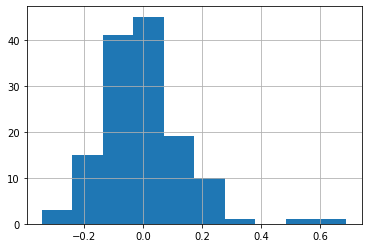

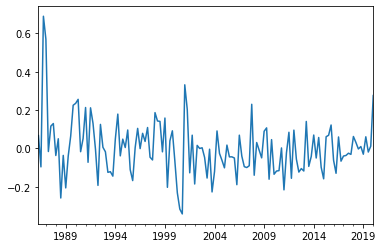

In [30]:
model.resid.hist()
plt.show()
model.resid.plot()

Let's backtest this a bit. Statsmodels makes it easy to do a one-quarter ahead backtest. While we care more about dynamic backtesting, this can be informative.

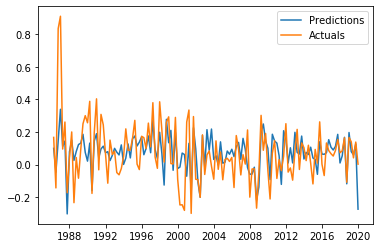

In [31]:
# find model predictions
predictions = model.predict(X)
# plot predictions against actuals
plt.plot(predictions.index, predictions, y.index, y)
plt.legend(['Predictions', 'Actuals'])

### Part 5: Diagnostics

As we approach our diagnostics, we recall that there are some fundamental assumptions of linear regression that must hold true with our model. These assumptions will be the focus of our diagnostics tests.
* Residuals are normally distributed
* All regression variables (independent and dependent) are stationary
* Heteroskedasticity is not present in the residuals
* Autocorrelation is not present in the residuals

while there are several methods to test each of these assumptions, we will just choose one for each for today. 

#### Residual Normality - Shapiro-Wilk Test

$H_0$: Residuals are normally distributed

$H_a$: Residuals are not normally distributed

We see below from our low p-value that our residuals show evidence of not being normally distributed, which is an issue.

In [32]:
sp.shapiro(model.resid)

(0.9330253601074219, 4.456813712749863e-06)

#### Stationarity of Variables - Augmented Dickey-Fuller Test
$H_0$: Unit root is present (variable is not stationary)

$H_a$: Unit root is not present (variable is stationary)

We see below from our low p-values on both our variables that they are stationary.


In [33]:
adfuller(y)

(-5.779606998136448,
 5.162594305814863e-07,
 2,
 133,
 {'1%': -3.480500383888377,
  '5%': -2.8835279559405045,
  '10%': -2.578495716547007},
 -112.68408719448911)

In [34]:
adfuller(X.iloc[:,1])

(-11.955311198093387,
 4.223335755473661e-22,
 0,
 135,
 {'1%': -3.479742586699182,
  '5%': -2.88319822181578,
  '10%': -2.578319684499314},
 -283.73635073592243)

#### Heteroskedasticity of Residuals - White's Test

$H_0$: Homoskedasticity

$H_a$: Heteroskedasticity

We see the p-value is 0.01, indicating that heteroskedasticity is an issue with this model.

In [35]:
sm.stats.diagnostic.het_white(model.resid, model.model.exog)

(8.857749994344147,
 0.011927901049868917,
 4.6329239461916325,
 0.011348552272043518)

We can use heteroskedasticity-consistent standard errors to check if our model specification is still significant in the presence of heteroskedasticity, and indeed it is. 

In [36]:
new = model.get_robustcov_results(cov_type='HAC', maxlags=1)
new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     Stock Price Quarterly % Growth   R-squared:                       0.352
Model:                                        OLS   Adj. R-squared:                  0.347
Method:                             Least Squares   F-statistic:                     41.24
Date:                            Wed, 03 Jun 2020   Prob (F-statistic):           2.16e-09
Time:                                    19:09:09   Log-Likelihood:                 70.367
No. Observations:                             136   AIC:                            -136.7
Df Residuals:                                 134   BIC:                            -130.9
Df Model:                                       1                                         
Covariance Type:                              HAC                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0441      0.013      3.515      0.001       0.019       0.069
Close          1.3674      0.213      6.422      0.000       0.946       1.789
==============================================================================
Omnibus:                       43.437   Durbin-Watson:                   1.596
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              133.380
Skew:                           1.178   Prob(JB):                     1.09e-29
Kurtosis:                       7.241   Cond. No.                         12.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

### Autocorrelation of Residuals - Breusch-Godfrey Test

$H_0$: No autocorrelation is present

$H_a$: Autocorrelation is present

We see from our p-value of 0.2 that autocorrelation does not seem to be present in this model. 

In [37]:
# note - we use 4 lags as that's the periodicity of the model 
sm.stats.diagnostic.acorr_breusch_godfrey(model, nlags=4, store=False) 

(5.958441218424532, 0.2022734799828453, 1.4891342537969865, 0.2091811367216205)